# HR Analytics: Job Change of Data Scientists

# Random Forest Model Performance

| Model              | Accuracy (testing set) | AUC score (testing set) |
| :--                | :--                    |:--                      |
| **Default**        | 0.855                  | 0.933                   |
| **Final Model**    | 0.860                  | 0.937                   |


**Footnote**
- Default model: The model using default hyper parameters.
- Final model: The model with tuned hyper parameters.

# Let's start the  hyper parameter optimization 

## Modules

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# use ggplot in python
from plotnine import *

import os # Set the working directory

pd.set_option('max_colwidth', None) # display all the info in the column. Not to truncate the display.

# Load the processed dataset

Data transformation that I have done:
1. Remove unneeded features
2. Distinguish categorical and continuous variables.
3. Impute missing values
4. Encode "ordinal variables"
5. One hot encode for "Nominal variable"
6. Impute minor outcome
7. Standardize numeric features

In [2]:
from numpy import genfromtxt

os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
X_train_scaled = genfromtxt('X_train_scaled.csv', delimiter=',')
X_test_scaled = genfromtxt('X_test_scaled.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
y_test = genfromtxt('y_test.csv', delimiter=',')

In [3]:
# feature name for the transformed X
feature_name = pd.read_csv('X_index.csv')['feature_name']
feature_name

0      city_development_index
1              training_hours
2                   x0_city_1
3                  x0_city_10
4                 x0_city_100
                ...          
148                x5_Pvt Ltd
149           education_level
150                experience
151              company_size
152              last_new_job
Name: feature_name, Length: 153, dtype: object

# Random Forest - Setup

In [4]:
# Gradient Boost Model
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score

# Plot
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Save and read grid search object
import joblib

### Create a function to evaluate model performance
This framework of the function is created by Aarshay Jain. I made a few adjustments for this project.

**reference**: Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [5]:
def modelfit(alg, X_train, y_train, X_test, y_test, 
             feature_name = feature_name,
             performCV=False, 
             printFeatureImportance=True, 
             cv_folds=5):
    
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train) # note: Disbursed is the outcomet/target (y).
        
    #Predict training set:
    train_predictions = alg.predict(      X_train )
    train_predprob    = alg.predict_proba(X_train )[:,1]
    
    #Predict test set:
    test_predictions = alg.predict      (  X_test )
    test_predprob    = alg.predict_proba(  X_test )[:,1]
    
    #Print model report:
    print ("------Training Set-------")
    print ("Model Report")
    print ("Accuracy : %.7g" % accuracy_score(y_train, train_predictions) )
    print ("AUC Score: %.7g" % roc_auc_score( y_train, train_predprob   ) )
    
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validate(alg, X_train, y_train, 
                                  cv=cv_folds, n_jobs=3, 
                                  scoring=['roc_auc','accuracy'])
        # scoring parameter:
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        roc_auc= cv_score['test_roc_auc']
        acc    = cv_score['test_accuracy']
        
        print ("------ CV approach using training set -------")
        
        print ("CV roc_auc : Mean - %.7g | Std - %.7g" %( np.mean(roc_auc), np.std(roc_auc) ) 
              )
        
        print ("CV accuracy: Mean - %.7g | Std - %.7g" %( np.mean(acc), np.std(acc) )
              )
        
    #Print model report:
    print ("------Testing Set-------")
    print ("Model Report")
    print ("Accuracy : %.7g" % accuracy_score(y_test, test_predictions) )
    print ("AUC Score: %.7g" % roc_auc_score( y_test, test_predprob   ) )    
                
    #Print Feature Importance:
    if printFeatureImportance:
        print ("\n")
        print ("------Feature Importance Score based on Training Set-------")
        feat_imp = pd.Series(data= alg.feature_importances_, index= feature_name).sort_values(ascending=False)
        feat_imp_filter = feat_imp[feat_imp> 0.01]
        
        #### Plot
        feat_imp_filter.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# Create a function to find the optimal parameter according to grid search

In [6]:
def fnc_show_best_param(grid_search):
    gsearch = grid_search
    params = np.array( [x for x in gsearch.cv_results_['params']] )
    cv_score_testset_during_cv = gsearch.cv_results_['mean_test_score']
    my_dict= {'params':params,'cv_score_testset_during_cv': cv_score_testset_during_cv}
    df = pd.DataFrame(my_dict).sort_values(by='cv_score_testset_during_cv',ascending=False)
    print(df)

# Baseline Model
All parameters follow the default.

------Training Set-------
Model Report
Accuracy : 0.9993046
AUC Score: 0.9999978
------Testing Set-------
Model Report
Accuracy : 0.8550322
AUC Score: 0.9326611


------Feature Importance Score based on Training Set-------


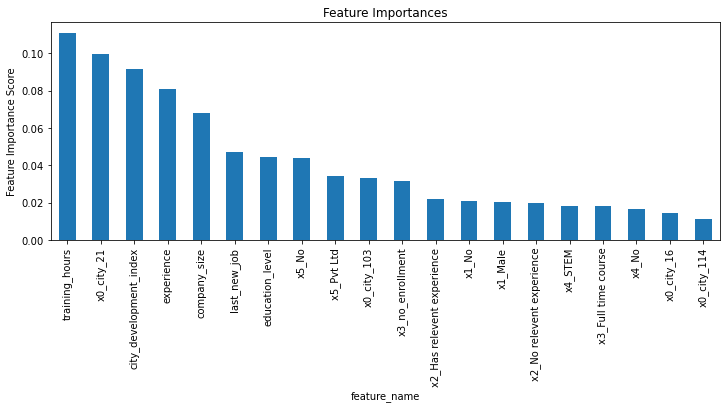

In [7]:
rf0 = RandomForestClassifier(random_state=10)
modelfit(rf0, X_train_scaled , y_train, X_test_scaled, y_test)

## Hyper Parameter
- max_depth
- min_samples_split
- min_impurity_decrease
- min_samples_leaf
- n_estimators
- max_sample (bootstrap sample)
- max_features

## Select the initial parameter settings

- min_samples_split = ~ 0.01 * total_observations : This should be 0.5-1% of total values.

- min_samples_leaf = 50 : Can be selected based on intuition. I will tune this using cross validation.

- max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.

In [8]:
X_train_scaled.shape[0]*0.01

230.09

# Step 1: max_depth and n_estimators

grind cv is using the training set

In [105]:
[x for x in range(10,31,10)]

[10, 20, 30]

In [110]:
param_test = {'max_depth':[30, 50, 100, 500, 1000] + [None], 
              'n_estimators': [100, 500, 1500, 2000]}

gsearch_1 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             
                             # Not Tuned
                             # n_estimators= 100,     # default
                             min_samples_split=2,     # default
                             min_samples_leaf =1,     # default 
                             max_features='sqrt',     # default
                             max_leaf_nodes = None,   # default
                             max_samples = None,      # default
                             random_state=10), 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=3,
                         cv=5)

gsearch_1.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_1, 'rf_gsearch_1.pkl')

['rf_gsearch_1.pkl']

In [111]:
### Read grid search results ####
gsearch_1 = joblib.load("rf_gsearch_1.pkl")
fnc_show_best_param(gsearch_1)

                                       params  cv_score_testset_during_cv
2     {'max_depth': 30, 'n_estimators': 1500}                    0.931742
3     {'max_depth': 30, 'n_estimators': 2000}                    0.931736
1      {'max_depth': 30, 'n_estimators': 500}                    0.931548
0      {'max_depth': 30, 'n_estimators': 100}                    0.930622
7     {'max_depth': 50, 'n_estimators': 2000}                    0.930107
11   {'max_depth': 100, 'n_estimators': 2000}                    0.930023
19  {'max_depth': 1000, 'n_estimators': 2000}                    0.930023
15   {'max_depth': 500, 'n_estimators': 2000}                    0.930023
23  {'max_depth': None, 'n_estimators': 2000}                    0.930023
6     {'max_depth': 50, 'n_estimators': 1500}                    0.930014
10   {'max_depth': 100, 'n_estimators': 1500}                    0.929990
14   {'max_depth': 500, 'n_estimators': 1500}                    0.929990
18  {'max_depth': 1000, 'n_estimators'

#### Great! Let's do fine grid search

In [118]:
param_test = {'max_depth':[25,30,35,40], 
              'n_estimators': [1400, 1500, 1600, 1700, 1800, 1900, 2000]}

gsearch_1_1 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             
                             # Not Tuned
                             # n_estimators= 100,     # default
                             min_samples_split=2,     # default
                             min_samples_leaf =1,     # default 
                             max_features='sqrt',     # default
                             max_leaf_nodes = None,   # default
                             max_samples = None,      # default
                             random_state=10), 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=3,
                         cv=5)

gsearch_1_1.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_1_1, 'rf_gsearch_1_1.pkl')

['rf_gsearch_1_1.pkl']

In [120]:
### Read grid search results ####
gsearch_1_1 = joblib.load("rf_gsearch_1_1.pkl")
fnc_show_best_param(gsearch_1_1)

                                     params  cv_score_testset_during_cv
9   {'max_depth': 30, 'n_estimators': 1600}                    0.931748
6   {'max_depth': 25, 'n_estimators': 2000}                    0.931746
8   {'max_depth': 30, 'n_estimators': 1500}                    0.931742
13  {'max_depth': 30, 'n_estimators': 2000}                    0.931736
10  {'max_depth': 30, 'n_estimators': 1700}                    0.931732
11  {'max_depth': 30, 'n_estimators': 1800}                    0.931730
5   {'max_depth': 25, 'n_estimators': 1900}                    0.931728
7   {'max_depth': 30, 'n_estimators': 1400}                    0.931722
12  {'max_depth': 30, 'n_estimators': 1900}                    0.931719
3   {'max_depth': 25, 'n_estimators': 1700}                    0.931703
4   {'max_depth': 25, 'n_estimators': 1800}                    0.931700
1   {'max_depth': 25, 'n_estimators': 1500}                    0.931687
2   {'max_depth': 25, 'n_estimators': 1600}                    0

# Step 2: min_samples_split

In [121]:
[2] + [x for x in range(50,501,50)]

[2, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [124]:
param_test = {'min_samples_split': [2] + [x for x in range(50,501,50)] }

gsearch_2 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             
                             # Not Tuned
                             min_samples_leaf =1,     # default 
                             max_features='sqrt',     # default
                             max_leaf_nodes = None,   # default
                             max_samples = None,      # default
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_2.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2, 'rf_gsearch_2.pkl')

['rf_gsearch_2.pkl']

In [125]:
#### Read grid search results ####
gsearch_2 = joblib.load("rf_gsearch_2.pkl")
fnc_show_best_param(gsearch_2)

                        params  cv_score_testset_during_cv
0     {'min_samples_split': 2}                    0.931748
1    {'min_samples_split': 50}                    0.930948
2   {'min_samples_split': 100}                    0.928353
3   {'min_samples_split': 150}                    0.926256
4   {'min_samples_split': 200}                    0.924270
5   {'min_samples_split': 250}                    0.922504
6   {'min_samples_split': 300}                    0.921026
7   {'min_samples_split': 350}                    0.919509
8   {'min_samples_split': 400}                    0.918116
9   {'min_samples_split': 450}                    0.916904
10  {'min_samples_split': 500}                    0.915593


In [128]:
param_test = {'min_samples_split': [0,2,6,10,20,30,40,50] }

gsearch_2_1 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             
                             # Not Tuned
                             max_features='sqrt',     # default
                             max_leaf_nodes = None,   # default
                             max_samples = None,      # default
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_2_1.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2_1, 'rf_gsearch_2_1.pkl')

C:\Users\15177\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.9317476  0.9329489  0.93313023 0.93261455 0.93208923
 0.93155404 0.93094829]


['gsearch_2_1.pkl']

In [134]:
#### Read grid search results ####
gsearch_2_1 = joblib.load("rf_earch_2_1.pkl")
fnc_show_best_param(gsearch_2_1)

                      params  cv_score_testset_during_cv
3  {'min_samples_split': 10}                    0.933130
2   {'min_samples_split': 6}                    0.932949
4  {'min_samples_split': 20}                    0.932615
5  {'min_samples_split': 30}                    0.932089
1   {'min_samples_split': 2}                    0.931748
6  {'min_samples_split': 40}                    0.931554
7  {'min_samples_split': 50}                    0.930948
0   {'min_samples_split': 0}                         NaN


# Step 3: max_leaf_nodes  and min_impurity_decrease 

In [16]:
param_test = {'max_leaf_nodes': [None, 1000, 3000],
             'min_impurity_decrease': [0, 0.1, 1e-20]}

gsearch_3 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             min_samples_split = 10,
                             
                             # Not Tuned
                             max_features='sqrt',     # default
                             max_samples = None,      # default
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=3,
                         cv=5)

gsearch_3.fit(X_train_scaled, y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_3, 'rf_gsearch_3.pkl')

['rf_gsearch_3.pkl']

In [17]:
#### Read grid search results ####
gsearch_3 = joblib.load("rf_gsearch_3.pkl")
fnc_show_best_param(gsearch_3)

                                                     params  \
0      {'max_leaf_nodes': None, 'min_impurity_decrease': 0}   
2  {'max_leaf_nodes': None, 'min_impurity_decrease': 1e-20}   
6      {'max_leaf_nodes': 3000, 'min_impurity_decrease': 0}   
8  {'max_leaf_nodes': 3000, 'min_impurity_decrease': 1e-20}   
3      {'max_leaf_nodes': 1000, 'min_impurity_decrease': 0}   
5  {'max_leaf_nodes': 1000, 'min_impurity_decrease': 1e-20}   
1    {'max_leaf_nodes': None, 'min_impurity_decrease': 0.1}   
4    {'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.1}   
7    {'max_leaf_nodes': 3000, 'min_impurity_decrease': 0.1}   

   cv_score_testset_during_cv  
0                    0.933130  
2                    0.933130  
6                    0.933017  
8                    0.933017  
3                    0.932530  
5                    0.932530  
1                    0.500000  
4                    0.500000  
7                    0.500000  


### max_leaf_nodes': None, 'min_impurity_decrease': 0 is the best combination

# Step 4: min_samples_leaf


In [18]:
param_test = {'min_samples_leaf': range(1,10,1)}

gsearch_4 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             min_samples_split = 10,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             
                             # Not Tuned
                             max_features='sqrt',     # default
                             max_samples = None,      # default
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=3,
                         cv=5)
gsearch_4.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_4, 'rf_gsearch_4.pkl')

['rf_gsearch_4.pkl']

In [19]:
#### Read grid search results ####
gsearch_4 = joblib.load("rf_gsearch_4.pkl")
fnc_show_best_param(gsearch_4)

                    params  cv_score_testset_during_cv
0  {'min_samples_leaf': 1}                    0.933130
1  {'min_samples_leaf': 2}                    0.931395
2  {'min_samples_leaf': 3}                    0.929610
3  {'min_samples_leaf': 4}                    0.927985
4  {'min_samples_leaf': 5}                    0.926578
5  {'min_samples_leaf': 6}                    0.925514
6  {'min_samples_leaf': 7}                    0.924443
7  {'min_samples_leaf': 8}                    0.923530
8  {'min_samples_leaf': 9}                    0.922641


# Step 5: max_samples


In [24]:
[None] +[range(9500,17501,1000)] 

[None, range(9500, 17501, 1000)]

In [27]:
param_test = {'max_samples': [None] +[x for x in range(10000,17501,3000)]  }

gsearch_5 =  GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             min_samples_split = 10,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             min_samples_leaf=1, 
                             
                             # Not Tuned
                             max_features='sqrt',     # default
                             max_samples = None,      # default
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=3,
                         cv=5)

gsearch_5.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_5, 'rf_gsearch_5.pkl')

['rf_gsearch_5.pkl']

In [28]:
#### Read grid search results ####
gsearch_5 = joblib.load("rf_gsearch_5.pkl")
fnc_show_best_param(gsearch_5)

                   params  cv_score_testset_during_cv
0   {'max_samples': None}                    0.933130
3  {'max_samples': 16000}                    0.932825
2  {'max_samples': 13000}                    0.932516
1  {'max_samples': 10000}                    0.931950


# Step 6: max_features

In [32]:
np.sqrt(X_train_scaled.shape[1])

12.36931687685298

In [33]:
param_test = {'max_features': range(9,16,1)}

gsearch_6 = GridSearchCV(estimator = 
                         RandomForestClassifier(
                             # Tuned parameter
                             max_depth= 30, 
                             n_estimators= 1600,
                             min_samples_split = 10,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             min_samples_leaf=1, 
                             max_samples= None,
                             
                             # Not Tuned
                             random_state=10),
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_6.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_6, 'rf_gsearch_6.pkl')

['gsearch_6.pkl']

In [34]:
#### Read grid search results ####
gsearch_6 = joblib.load("rf_gsearch_6.pkl")
fnc_show_best_param(gsearch_6)

                 params  cv_score_testset_during_cv
3  {'max_features': 12}                    0.933130
5  {'max_features': 14}                    0.933079
6  {'max_features': 15}                    0.933077
2  {'max_features': 11}                    0.933074
4  {'max_features': 13}                    0.933068
1  {'max_features': 10}                    0.933037
0   {'max_features': 9}                    0.932749


# Evaludate the Final model using the testing set

------Training Set-------
Model Report
Accuracy : 0.9286801
AUC Score: 0.9848681
------Testing Set-------
Model Report
Accuracy : 0.8604207
AUC Score: 0.9370609


------Feature Importance Score based on Training Set-------


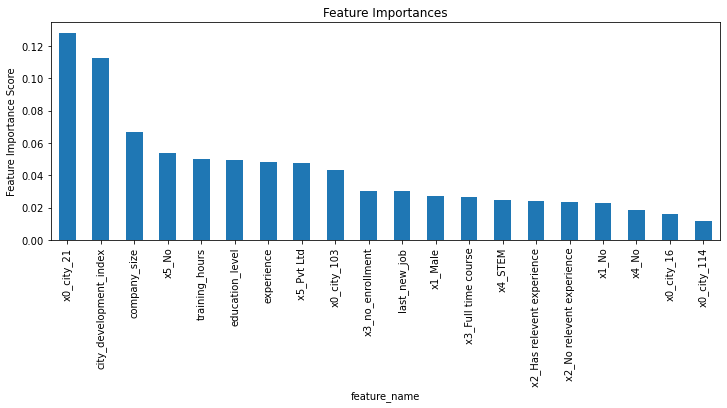

In [31]:
modelfit(gsearch_6.best_estimator_, X_train_scaled , y_train, X_test_scaled, y_test)

# End